In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np

import os
import glob
import re

from qwen import load_qwen
import torch
import torch.nn as nn

/home/ljf1/dis/lora/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model, tokenizer = load_qwen()

class LoRALinear(nn.Module):
    def __init__(self, original_linear: nn.Linear, r: int, alpha: int = None):
        super().__init__()
        assert isinstance(original_linear, nn.Linear)
        self.original_linear = original_linear
        self.original_linear.weight.requires_grad = False
        if self.original_linear.bias is not None:
            self.original_linear.bias.requires_grad = False
        in_dim = original_linear.in_features
        out_dim = original_linear.out_features
        self.r = r
        self.alpha = alpha if alpha else r

        device = original_linear.weight.device
        self.A = nn.Parameter(torch.empty(r, in_dim, device=device))
        self.B = nn.Parameter(torch.zeros(out_dim, r, device=device))
        
        # Initialise A with He initialization
        nn.init.kaiming_normal_(self.A, nonlinearity="linear")

    def forward(self, x):
        base_out = self.original_linear(x)
        lora_out = (x @ self.A.T) @ self.B.T
        return base_out + lora_out * (self.alpha / self.r)


model, tokenizer = load_qwen()
tokenizer.padding_side = 'left'

# Actually apply LoRA to the model:
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=8, alpha = 8)
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=8, alpha = 8)
# ^These are the parts that will actually be trained!

for name, param in model.named_parameters():
    if "A" in name or "B" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [14]:
layer_gradients = {}

In [ ]:
for name, param in model.named_parameters():
    if param.grad is None:
        continue
    if ("A" in name or "B" in name) and ("q_proj" in name or "v_proj" in name):
        parts = name.split(".")
        idx = parts[2]
        proj = parts[4]
        matrix = parts[-1]
        key = "{}.{}.{}".format(idx, proj, matrix)
        grad_norm = param.grad.detach().cpu().norm().item()
        layer_gradients[(key)] = grad_norm
        print(key)
        # print(parts)

: 

In [17]:
best_overall_params = {}

In [ ]:
best_val_loss = 1000
best_params = None

all_train_loss = []
all_val_loss = []
all_keys = []

best_val_loss = 1000
best_file = None

# Find all grid_results joblib files in the results folder
pattern = r'grid_results_\d+_[\d.e+-]+\.joblib'


# Get all files in the results directory
result_files = glob.glob('../results/*')

# Filter files that match the pattern
result_files = [file for file in result_files if re.search(pattern, file)]
print(result_files)

# Display the content of each file
for file_path in result_files:
    # Load the joblib file
    result = joblib.load(file_path)
    
    key = next(iter(result.keys()))
    print(f"Key: {key}: ", result[key]['final_val_loss'])

    all_train_loss.append(result[key]['train_losses'])
    all_val_loss.append(result[key]['val_losses'])
    all_keys.append(key)
    
    # Check if the current file has the best validation loss
    if result[key]['final_val_loss'] < best_val_loss:
        best_val_loss = result[key]['final_val_loss']
        best_file = key

print(f"\n{'='*50}")
print(f"Best validation loss: {best_val_loss}")
print(f"Best file: {best_file}")
print(f"{'='*50}")

best_overall_params['lora_rank'] = best_file[0]
best_overall_params['learning_rate'] = best_file[1]

['../results/grid_results_2_5e-05.joblib', '../results/grid_results_8_5e-05.joblib', '../results/grid_results_4_1e-05.joblib', '../results/grid_results_4_0.0001.joblib', '../results/grid_results_4_5e-05.joblib', '../results/grid_results_8_1e-05.joblib', '../results/grid_results_8_0.0001.joblib', '../results/grid_results_2_0.0001.joblib', '../results/grid_results_2_1e-05.joblib']
Key: (2, 5e-05):  0.7770885364214579
Key: (8, 5e-05):  0.7065702283382416
Key: (4, 1e-05):  2.1818896118799844
Key: (4, 0.0001):  0.6955302548408508
Key: (4, 5e-05):  0.7260950009028116
Key: (8, 1e-05):  0.9632526071866353
Key: (8, 0.0001):  0.675239432255427
Key: (2, 0.0001):  0.7159511244297028
Key: (2, 1e-05):  2.9407136766115824

Best validation loss: 0.675239432255427
Best file: (8, 0.0001)


In [19]:
all_train_loss = np.array(all_train_loss)
all_val_loss = np.array(all_val_loss)
all_keys = np.array(all_keys)

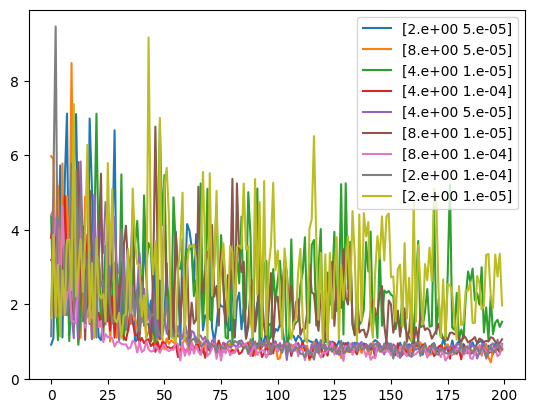

In [20]:
fig, ax = plt.subplots()
for i in range(len(all_train_loss)):
    ax.plot(all_train_loss[i, :, 1], all_train_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

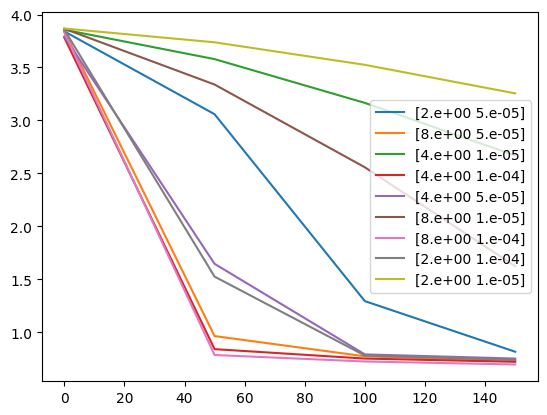

In [21]:
fig, ax = plt.subplots()
for i in range(len(all_val_loss)):
    ax.plot(all_val_loss[i, :, 1], all_val_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

In [22]:
best_val_loss = 1000
best_params = None

all_train_loss = []
all_val_loss = []
all_keys = []

best_val_loss = 1000
best_file = None

# Pattern to match files of the form grid_results_NUMBER.joblib
pattern = r'grid_results_\d+\.joblib'

# Get all files in the results directory
result_files = glob.glob('../results/*')

# Filter files that match the pattern (just one number after grid_results_)
result_files = [file for file in result_files if re.search(pattern, file)]

print(result_files)

# Display the content of each file
for file_path in result_files:
    # Load the joblib file
    result = joblib.load(file_path)
    
    key = next(iter(result.keys()))
    print(f"Key: {key}: ", result[key]['final_val_loss'])

    all_train_loss.append(result[key]['train_losses'])
    all_val_loss.append(result[key]['val_losses'])
    all_keys.append(key)
    
    # Check if the current file has the best validation loss
    if result[key]['final_val_loss'] < best_val_loss:
        best_val_loss = result[key]['final_val_loss']
        best_file = key

print(f"\n{'='*50}")
print(f"Best validation loss: {best_val_loss}")
print(f"Best file: {best_file}")
print(f"{'='*50}")

best_overall_params['max_ctx_length'] = best_file

['../results/grid_results_128.joblib', '../results/grid_results_768.joblib', '../results/grid_results_512.joblib']
Key: 128:  0.8882208197116852
Key: 768:  0.6628554898500443
Key: 512:  0.6629896704355875

Best validation loss: 0.6628554898500443
Best file: 768


In [23]:
all_train_loss = np.array(all_train_loss)
all_val_loss = np.array(all_val_loss)

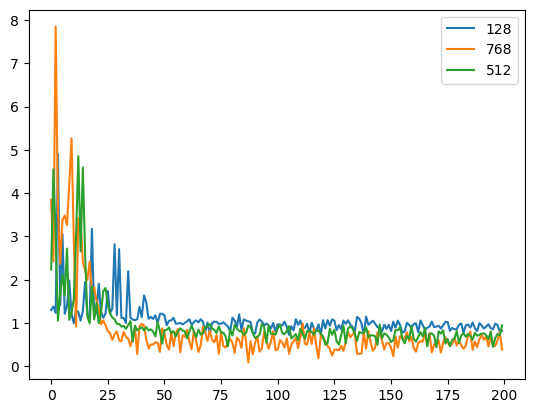

In [24]:
fig, ax = plt.subplots()
for i in range(len(all_train_loss)):
    ax.plot(all_train_loss[i, :, 1], all_train_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

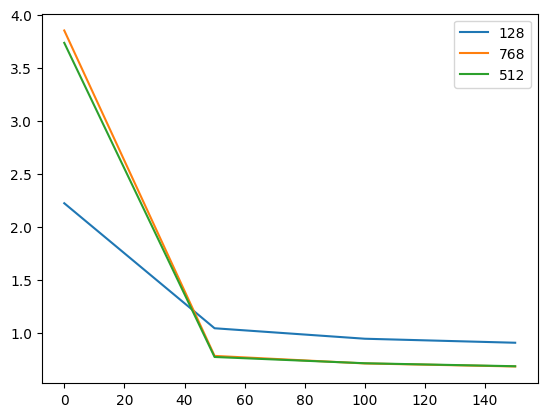

In [25]:
fig, ax = plt.subplots()
for i in range(len(all_val_loss)):
    ax.plot(all_val_loss[i, :, 1], all_val_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

In [26]:
best_val_loss = 1000
best_params = None

all_train_loss = []
all_val_loss = []
all_keys = []

best_val_loss = 1000
best_file = None

# Pattern to match files of the form grid_results_WORDS.joblib
pattern = r'grid_results_[a-zA-Z]+\.joblib'

# Get all files in the results directory
result_files = glob.glob('../results/*')

# Filter files that match the pattern (just one number after grid_results_)
result_files = [file for file in result_files if re.search(pattern, file)]

print(result_files)

# Display the content of each file
for file_path in result_files:
    # Load the joblib file
    result = joblib.load(file_path)
    
    key = next(iter(result.keys()))
    print(f"Key: {key}: ", result[key]['final_val_loss'])

    all_train_loss.append(result[key]['train_losses'])
    all_val_loss.append(result[key]['val_losses'])
    all_keys.append(key)
    
    # Check if the current file has the best validation loss
    if result[key]['final_val_loss'] < best_val_loss:
        best_val_loss = result[key]['final_val_loss']
        best_file = key

print(f"\n{'='*50}")
print(f"Best validation loss: {best_val_loss}")
print(f"Best file: {best_file}")
print(f"{'='*50}")

best_overall_params['scheduler_choice'] = best_file

['../results/grid_results_CosineAnnealingLR.joblib', '../results/grid_results_CosineScheduleWithWarmup.joblib', '../results/grid_results_StepLR.joblib']
Key: CosineAnnealingLR:  0.6538862562179566
Key: CosineScheduleWithWarmup:  3.8823856496810913
Key: StepLR:  0.6664091555277506

Best validation loss: 0.6538862562179566
Best file: CosineAnnealingLR


In [27]:
all_train_loss = np.array(all_train_loss)
all_val_loss = np.array(all_val_loss)

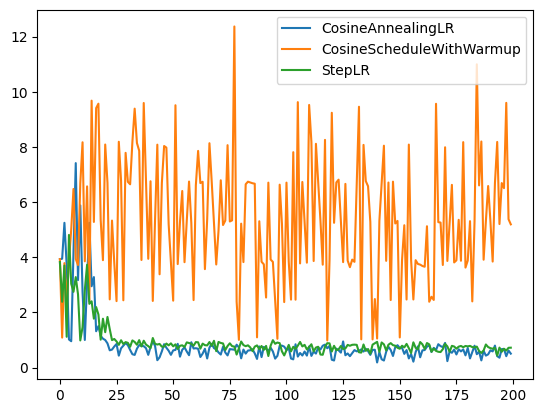

In [28]:
fig, ax = plt.subplots()
for i in range(len(all_train_loss)):
    ax.plot(all_train_loss[i, :, 1], all_train_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

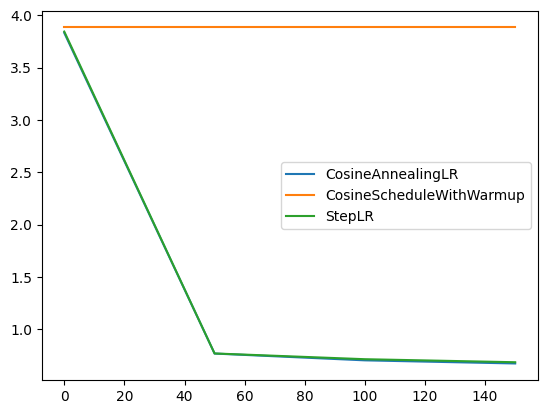

In [29]:
fig, ax = plt.subplots()
for i in range(len(all_val_loss)):
    ax.plot(all_val_loss[i, :, 1], all_val_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

In [30]:
joblib.dump(best_overall_params, "best_overall_params.joblib")

['best_overall_params.joblib']